# Analysis of libjpeg - DCT method in compression

**Author:** Martin Beneš

This notebook contains forensic analysis of DCT method parameters in various libjpeg versions. Both RGB and grayscale are tested separately. All the other parameters are kept default.

In [1]:
# versions to test
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d','9e']

# default versions
import jpeglib
v_arbitrary = '9e' # arbitrary version for decompression
jpeglib.version.set(v_arbitrary)

# random subsample size
N_samples = 10

# database path
from pathlib import Path
db_path = Path.home() / 'Datasets'

# checkerboard
import numpy as np
def checkerboard(boardsize, tilesize, channels=3):
    board = np.zeros([*boardsize, channels], dtype=np.uint8)
    for i in range(boardsize[0]):
        for j in range(boardsize[1]):
            if (i//tilesize[0]) % 2 == (j//tilesize[1]) % 2:
                board[i,j] = 255
    return board

# dct methods to test
dct_methods = [dct for dct in jpeglib.DCTMethod.J_DCT_METHOD().keys() if dct is not None]
dct_methods

['JDCT_ISLOW', 'JDCT_IFAST', 'JDCT_FLOAT']

## Load BOSS

Load BOSSBase database consisting of 10000 grayscale images. It can be downloaded [here](http://agents.fel.cvut.cz/boss/index.php?mode=VIEW&tmpl=materials). For faster execution, we only work with its subsample.

In [2]:
# list BOSS database
import os
boss_path = db_path / 'BOSS_raw' / 'BOSS_from_raw'
boss_names = [boss_path / f for f in os.listdir(boss_path)]
print("Loaded BOSS database with", len(boss_names), "images.")

# sample without replacement
import random
random.seed(42) # answer to everything
boss_names_sub = random.sample(boss_names, N_samples-2)

# choose most and least saturated
#import cv2
#most,least = (None,0),(None,0)
#for i,f in enumerate(boss_names):
#    if i % 500 == 0: print(i, '/', len(boss_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'png': continue
#    x = cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (boss_path / '6900_1_3.png',262144),(boss_path / '6155_1_6.png', 88944)
# add them
boss_names_sub.append(most[0])
boss_names_sub.append(least[0])

# load the grayscale image with cv2
import cv2
boss = np.array([np.array(cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)) for f in boss_names_sub])
boss = np.expand_dims(boss, axis=3)

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    boss = np.append(boss, np.expand_dims(checkerboard((512, 512), tilesize, channels=1), 0), 0)

print("Input shape", boss.shape)

Loaded BOSS database with 23152 images.
Input shape (15, 512, 512, 1)


## Load ALASKA

Load ALASKA2 database consisting of 70000 colored images. In this case we have uncompressed version of shape 256x256. You can find the scripts to download it [here](https://alaska.utt.fr/).

In [3]:
# Load ALASKA2 database
alaska_path = db_path / 'ALASKA_v2_TIFF_256_COLOR'
alaska_names = [alaska_path / f for f in os.listdir(alaska_path)]
print("Loaded ALASKA2 database with", len(alaska_names), "images.")

# sample without replacement
random.seed(42) # answer to everything
alaska_names_sub = random.sample(alaska_names, N_samples-2)

# choose most and least saturated
import matplotlib.pyplot as plt
#most,least = (None,0),(None,0)
#for i,f in enumerate(alaska_names):
#    if i % 500 == 0: print(i, '/', len(alaska_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'tif': continue
#    x = plt.imread(str(f))
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (alaska_path / '10343.tif',98491),(alaska_path / '05887.tif', 78128)
# add them
alaska_names_sub.append(most[0])
alaska_names_sub.append(least[0])

# load the image with PIL
import matplotlib.pyplot as plt
alaska = np.array([plt.imread(f) for f in alaska_names_sub])

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    alaska = np.append(alaska, np.expand_dims(checkerboard((256, 256), tilesize, 3), 0), 0)

print("Input shape", alaska.shape)

Loaded ALASKA2 database with 80004 images.
Input shape (15, 256, 256, 3)


## Impact magnitude

In [4]:
# iterate all versions
import tempfile
images_rgb = {v: {} for v in versions}
images_Y = {v: {} for v in versions}
images_Cb = {v: {} for v in versions}
images_Cr = {v: {} for v in versions}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate compression dct method
    for i,dct_method in enumerate(dct_methods):
        
        # evaluate for all the versions
        for v_compress in versions:
            
            # compress each image with all dct methods
            with jpeglib.version(v_compress):
                fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
                for i,fname in enumerate(fnames):
                    im = jpeglib.from_spatial(alaska[i])
                    im.samp_factor = ((2,2),(1,1),(1,1))
                    im.write_spatial(fname, dct_method=dct_method, qt=75)
                    
            # decompress each image with arbitrary dct method
            with jpeglib.version(v_arbitrary):
                images_rgb[v_compress][dct_method] = np.array([
                    jpeglib.read_spatial(fname).spatial for fname in fnames
                ])
                images_Y[v_compress][dct_method] = np.array([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ])
                images_Cb[v_compress][dct_method] = np.array([
                    jpeglib.read_dct(fname).Cb for fname in fnames
                ])
                images_Cr[v_compress][dct_method] = np.array([
                    jpeglib.read_dct(fname).Cr for fname in fnames
                ])

We shall take a look in particular in the difference images between JPEGs compressed with different DCT methods.

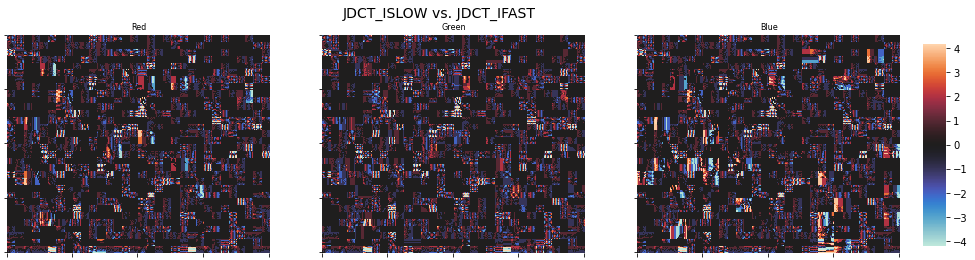

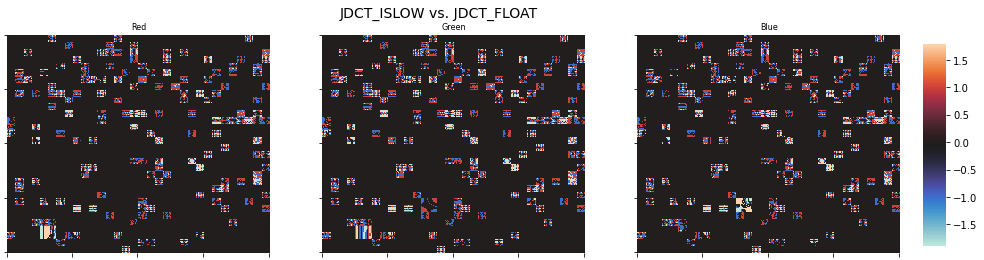

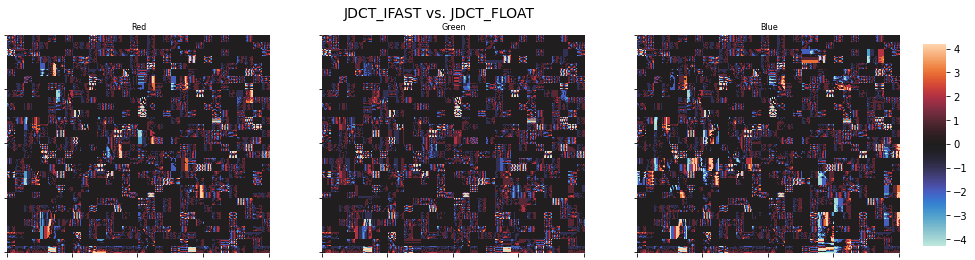

In [5]:
# difference metric
mismatch = lambda x1,x2: (x1.astype(np.int16) - x2.astype(np.int16))

# iterate all combinations of dct methods
for i,dct1 in enumerate(dct_methods):
    for j,dct2 in enumerate(dct_methods[i+1:]):

        # difference
        D = mismatch(images_rgb['6b'][dct1], images_rgb['6b'][dct2])
        
        # plots
        import seaborn as sns
        fig,axs = plt.subplots(1,3, figsize=(16,4), sharey=True)
        cbar_ax = fig.add_axes([.92, .15, .02, .7])
        vmin,vmax = D.mean() - 3*D.std(), D.mean() + 3*D.std() # three sigma
        for k,(ax,title) in enumerate(zip(axs.flat,['Red','Green','Blue'])):
            p = sns.heatmap(D[0,:,:,k], cbar=k==0, vmin=vmin, vmax=vmax,
                            cmap=sns.color_palette("icefire", as_cmap=True),
                            ax=ax, cbar_ax=None if k else cbar_ax)
            p.set_xticks([0,63,127,191,255])
            p.set_yticks([0,63,127,191,255])
            p.set_title(title, fontsize=8)
        fig.suptitle(f'{dct1} vs. {dct2}', fontsize=14)
        #plt.savefig(f'{dct1}_{dct2}.png', dpi=600)

Let's visualize the distribution of the differences (over all channels).

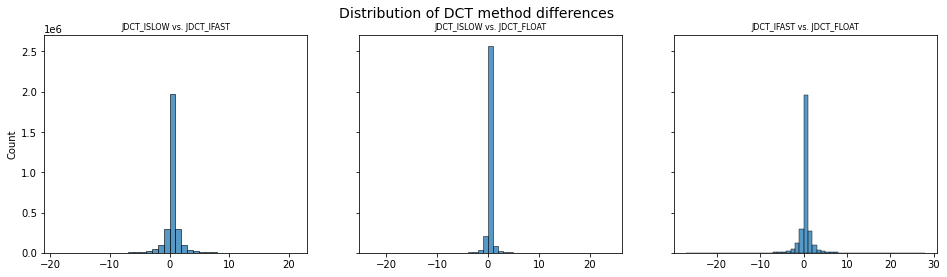

In [6]:
# plots
fig,axs = plt.subplots(1,3, figsize=(16,4), sharey=True)
fig.suptitle(f'Distribution of DCT method differences', fontsize=14)
it = 0

# iterate all combinations of dct methods
for i,dct1 in enumerate(dct_methods):
    for dct2 in dct_methods[i+1:]:

        # difference
        D = mismatch(images_rgb['6b'][dct1], images_rgb['6b'][dct2])
        
        # plots
        p = sns.histplot(D.flatten(), binwidth=1, ax=axs[it])
        p.set_title(f'{dct1} vs. {dct2}', fontsize=8)
        it += 1

# save figure
#plt.savefig(f'distr_dct_diff.png', dpi=600)

## Colored with downsampling

In [7]:
# images recompressed by each version
images_rgb_samp = {'version': [], 'dct_method': [], 'Y': [], 'Cb': [], 'Cr': [], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # iterate dct methods
        for dct_method in dct_methods:
            
            # compress each image with version
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
            with jpeglib.version(v_compress):
                for i,fname in enumerate(fnames):
                    im = jpeglib.from_spatial(alaska[i])
                    im.samp_factor = ((2,2),(1,1),(1,1))
                    im.write_spatial(fname, dct_method=dct_method)
        
            # decompress with single (arbitrary) version
            with jpeglib.version(v_arbitrary):
                images_rgb_samp['version'].append(v_compress)
                images_rgb_samp['dct_method'].append(dct_method)
                images_rgb_samp['image'].append(np.array([
                    jpeglib.read_spatial(fname).spatial for fname in fnames
                ]))
                images_rgb_samp['Y'].append([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ])
                images_rgb_samp['Cb'].append([
                    jpeglib.read_dct(fname).Cb for fname in fnames
                ])
                images_rgb_samp['Cr'].append([
                    jpeglib.read_dct(fname).Cr for fname in fnames
                ])

# dataframe
import pandas as pd
images_rgb_samp = pd.DataFrame(images_rgb_samp)

### N-to-N comparison

Let's compare each version with each other.

In [8]:
# distance metric
from scipy.spatial.distance import pdist, squareform
mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()

# images to distance matrix
distmats_rgb_samp = {}
for dct_method in dct_methods:
    images_rgb_samp_dct = images_rgb_samp[images_rgb_samp.dct_method == dct_method]
    
    images_rgb_samp_list = np.array([list(i) for i in images_rgb_samp_dct.image.to_list()])
    images_rgb_samp_list = images_rgb_samp_list.reshape(len(versions), -1)
    dists_rgb_samp = pdist(images_rgb_samp_list, mismatch)
    distmat_rgb_samp = squareform(dists_rgb_samp)
    distmats_rgb_samp[dct_method] = distmat_rgb_samp

To check whether there is nothing being cancelled out (symmetrically) by compression vs. decompression.

In [9]:
def get_distmat_dct(dct):
    # images to distance matrix
    images_dct_list = np.array([list(i) for i in dct.to_list()], dtype=object)
    images_dct_list = images_dct_list.reshape(len(versions), -1)
    dists_dct = pdist(images_dct_list, mismatch)
    distmat_dct = squareform(dists_dct)
    return distmat_dct

# images to distance matrix
distmats_Y_samp = {}
distmats_Cb_samp = {}
distmats_Cr_samp = {}
for dct_method in dct_methods:
    images_rgb_samp_dct = images_rgb_samp[images_rgb_samp.dct_method == dct_method]
    distmats_Y_samp[dct_method] = get_distmat_dct(images_rgb_samp_dct.Y)
    distmats_Cb_samp[dct_method] = get_distmat_dct(images_rgb_samp_dct.Cb)
    distmats_Cr_samp[dct_method] = get_distmat_dct(images_rgb_samp_dct.Cr)

    # check match with spatial
    print(dct_method)
    print('-', ((distmats_rgb_samp[dct_method] != 0) == (distmats_Y_samp[dct_method] != 0)).all())
    print('-', ((distmats_rgb_samp[dct_method] != 0) == (distmats_Cb_samp[dct_method] != 0)).all())
    print('-', ((distmats_rgb_samp[dct_method] != 0) == (distmats_Cr_samp[dct_method] != 0)).all())

JDCT_ISLOW
- False
- True
- True
JDCT_IFAST
- False
- True
- True
JDCT_FLOAT
- False
- True
- True


Turns out DCT and spatial have the same mismatch matrix.

### Clustering of spatial

In [10]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for dct_method in dct_methods:
    distmat_rgb_samp = distmats_rgb_samp[dct_method]
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_rgb_samp)
        
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_rgb_samp[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
JDCT_IFAST 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']
JDCT_FLOAT 3 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e'] ['6b', 'turbo210']


There are two clusters, identical to the ones already known from the subsampling.

### Clustering of luminance

In [11]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for dct_method in dct_methods:
    distmat_Y_samp = distmats_Y_samp[dct_method]
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_Y_samp)
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_Y_samp[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_IFAST 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_FLOAT 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']


### Mismatch matrix

JDCT_ISLOW


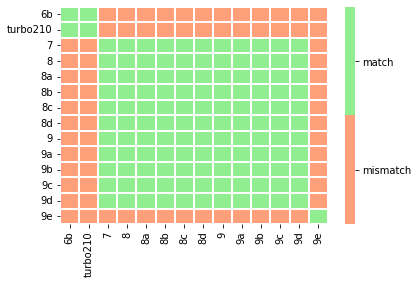

JDCT_IFAST


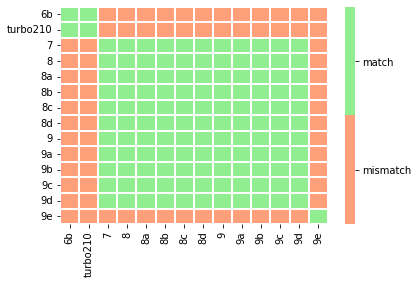

JDCT_FLOAT


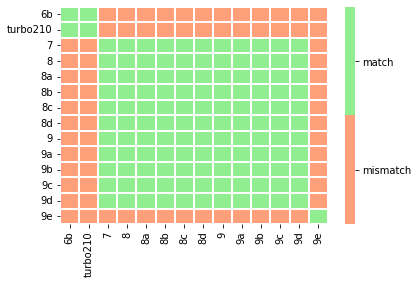

In [12]:
# create plot
import seaborn as sns
for dct_method in dct_methods:
    fig,ax = plt.subplots(1,1)
    sns.heatmap(
        pd.DataFrame(distmats_rgb_samp[dct_method] == 0, index=versions, columns=versions),
        linewidth=.05, ax=ax, cmap=['lightsalmon','lightgreen'])
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
    colorbar.set_ticklabels(['mismatch','match'])
    print(dct_method)
    plt.show();

If DCT has any difference in images with color subsampling, it overlaps with the mismatch described at color subsampling. As no such difference was observed in grayscale or color images without color subsampling, it seems DCT does not differ throughout the versions.

## Colored without downsampling

We evaluate impact on compression. As sampling factor causes difference, first we evaluate for no downsampling.

In [13]:
# images recompressed by each version
images_rgb = {'version': [], 'dct_method': [], 'image': [], 'Y': [], 'Cb': [], 'Cr': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # iterate dct methods
        for dct_method in dct_methods:
            
            # compress each image with version
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
            with jpeglib.version(v_compress):
                for i,fname in enumerate(fnames):
                    im = jpeglib.from_spatial(alaska[i])
                    im.samp_factor = ((1,1),(1,1),(1,1))
                    im.write_spatial(fname, qt=75, dct_method=dct_method)
        
            # decompress with single (arbitrary) version
            with jpeglib.version(v_arbitrary):
                images_rgb['version'].append(v_compress)
                images_rgb['dct_method'].append(dct_method)
                images_rgb['image'].append(np.array([
                    jpeglib.read_spatial(fname).spatial for fname in fnames
                ]))
                images_rgb['Y'].append([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ])
                images_rgb['Cb'].append([
                    jpeglib.read_dct(fname).Cb for fname in fnames
                ])
                images_rgb['Cr'].append([
                    jpeglib.read_dct(fname).Cr for fname in fnames
                ])

# dataframe
import pandas as pd
images_rgb = pd.DataFrame(images_rgb)

### N-to-N comparison

We compare each version with each version in all the DCT methods.

In [14]:
# images to distance matrix
distmats_rgb = {}
for dct_method in dct_methods:
    images_rgb_dct = images_rgb[images_rgb.dct_method == dct_method]
    
    images_rgb_list = np.array([list(i) for i in images_rgb_dct.image.to_list()])
    images_rgb_list = images_rgb_list.reshape(len(versions), -1)
    dists_rgb = pdist(images_rgb_list, mismatch)
    distmat_rgb = squareform(dists_rgb)
    distmats_rgb[dct_method] = distmat_rgb

In [15]:
distmats_Y = {}
distmats_Cb = {}
distmats_Cr = {}
for dct_method in dct_methods:
    images_rgb_dct = images_rgb[images_rgb.dct_method == dct_method]
    
    distmats_Y[dct_method] = get_distmat_dct(images_rgb_dct.Y)
    distmats_Cb[dct_method] = get_distmat_dct(images_rgb_dct.Cb)
    distmats_Cr[dct_method] = get_distmat_dct(images_rgb_dct.Cr)
    
    # check match with spatial
    print(dct_method)
    print("-", ((distmats_rgb[dct_method] == 0) == (distmats_Y[dct_method] == 0)).all())
    print("-", ((distmats_rgb[dct_method] == 0) == (distmats_Cb[dct_method] == 0)).all())
    print("-", ((distmats_rgb[dct_method] == 0) == (distmats_Cr[dct_method] == 0)).all())

JDCT_ISLOW
- False
- True
- True
JDCT_IFAST
- False
- True
- True
JDCT_FLOAT
- False
- True
- True


DCT coefficients and spatial representation match each other.

### Clustering of spatial

In [16]:
# cluster
for dct_method in dct_methods:
    distmat_rgb = distmats_rgb[dct_method]
    
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_rgb)
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_rgb[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
JDCT_IFAST 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
JDCT_FLOAT 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']


All the versions produce the same output. DCT method does not make a difference in colored images without subsampling.

### Clustering of luminance

In [17]:
# cluster
for dct_method in dct_methods:
    distmat_Y = distmats_Y[dct_method]
    
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_Y)
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_Y[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_IFAST 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_FLOAT 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']


### Mismatch matrix

JDCT_ISLOW


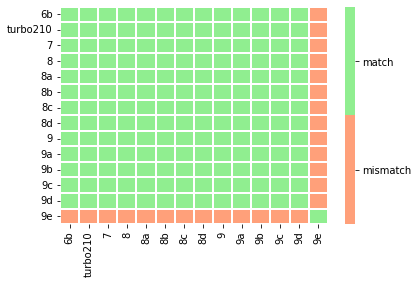

JDCT_IFAST


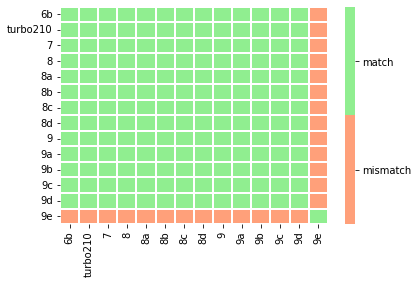

JDCT_FLOAT


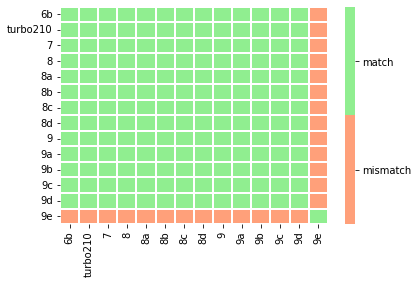

In [18]:
# create plot
import seaborn as sns
for dct_method in dct_methods:
    fig,ax = plt.subplots(1,1)
    sns.heatmap(
        pd.DataFrame(distmats_rgb[dct_method] == 0, index=versions, columns=versions),
        linewidth=.05, ax=ax, cmap=['lightsalmon','lightgreen'])
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
    colorbar.set_ticklabels(['mismatch','match'])
    print(dct_method)
    plt.show();

All the libraries produce the same output.

## Grayscale

Let's start with grayscale. We know that there is no difference in compression with default parameters and that is what we expect now.

In [23]:
# images recompressed by each version
images_gray = {'version': [], 'dct_method': [],'image': [], 'Y': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # iterate methods
        for dct_method in dct_methods:
            
            # compress each image with version and dct method
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(boss.shape[0])]
            with jpeglib.version(v_compress):
                [jpeglib.from_spatial(boss[i], 'JCS_GRAYSCALE').write_spatial(fname, dct_method=dct_method, qt=75)
                     for i,fname in enumerate(fnames)]
        
            # decompress with single (arbitrary) version
            with jpeglib.version(v_arbitrary):
                images_gray['version'].append(v_compress)
                images_gray['dct_method'].append(dct_method)
                images_gray['image'].append(np.array([
                    jpeglib.read_spatial(fname).spatial for fname in fnames
                ]))
                images_gray['Y'].append(np.array([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ]))

# dataframe
import pandas as pd
images_gray = pd.DataFrame(images_gray)

### N-to-N comparison

In [20]:
# images to distance matrix
distmats_gray = {}
for dct_method in dct_methods:
    images_gray_dct = images_gray[images_gray.dct_method == dct_method]
    
    images_gray_list = np.array([list(i) for i in images_gray_dct.image.to_list()])
    images_gray_list = images_gray_list.reshape(len(versions), -1)
    dists_gray = pdist(images_gray_list, mismatch)
    distmats_gray[dct_method] = squareform(dists_gray)

### Clustering

In [21]:
# cluster
for dct_method in dct_methods:
    distmat_gray = distmats_gray[dct_method]
    
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_gray)
    
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_gray[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
    
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_IFAST 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_FLOAT 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']


One cluster discovered with all the versions. DCT method does not make a difference for grayscale images.

### Mismatch matrix

JDCT_ISLOW


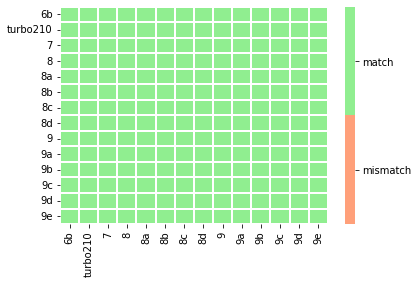

JDCT_IFAST


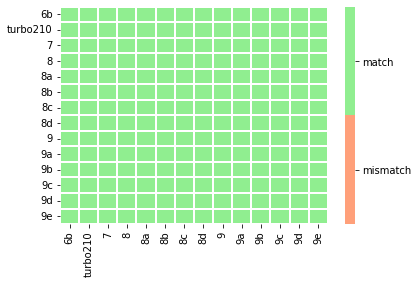

JDCT_FLOAT


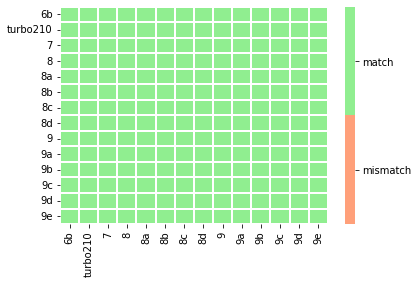

In [22]:
# create plot
import seaborn as sns
for dct_method in dct_methods:
    fig,ax = plt.subplots(1,1)
    sns.heatmap(
        pd.DataFrame(distmats_gray[dct_method] == 0, index=versions, columns=versions),
        linewidth=.05, ax=ax, cmap=['lightsalmon','lightgreen'])
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
    colorbar.set_ticklabels(['mismatch','match'])
    print(dct_method)
    plt.show();

No mismatches found between the versions.